In [1]:
import numpy as np
from transforms3d.euler import euler2mat, quat2euler
from transforms3d.quaternions import qconjugate, quat2axangle
from transforms3d.axangles import axangle2mat
from enum import Enum

In [2]:
class Configuration:
    def __init__(self):  
        #################### COMMANDS ####################
        self.max_x_velocity = 1
        self.max_y_velocity = 1
        self.max_yaw_rate = 2.0
        self.max_pitch = 30.0 * np.pi / 180.0
        
        #################### MOVEMENT PARAMS ####################
        self.z_time_constant = 0.02
        # self.z_speed = 0.03  # maximum speed [m/s]
        # self.pitch_deadband = 0.02
        # self.pitch_time_constant = 0.25
        # self.max_pitch_rate = 0.15
        # self.roll_speed = 0.16  # maximum roll rate [rad/s]
        self.yaw_time_constant = 0.3
        self.max_stance_yaw = 1.2
        self.max_stance_yaw_rate = 2.0

        #################### STANCE ####################
        self.delta_x = 0.1881
        self.delta_y = 0.12675
        self.x_shift = 0.0
        self.default_z_ref = -0.27
        
        #################### SWING ######################
        self.z_coeffs = None
        self.z_clearance = 0.2
        self.alpha = (
            0.5  # Ratio between touchdown distance and total horizontal stance movement
        )
        self.beta = (
            0.5  # Ratio between touchdown distance and total horizontal stance movement
        )

        #################### GAIT #######################
        self.dt = 0.01
        self.num_phases = 4
        self.contact_phases = np.array(
            [[1, 1, 1, 0], 
             [1, 0, 1, 1], 
             [1, 0, 1, 1], 
             [1, 1, 1, 0]]
        )
        self.overlap_time = (
            0.10  # duration of the phase where all four feet are on the ground
        )
        self.swing_time = (
            0.15  # duration of the phase when only two feet are on the ground
        )

        ######################## GEOMETRY ######################
        self.LEG_FB = 0.1881  # front-back distance from center line to leg axis
        self.LEG_LR = 0.04675 # left-right distance from center line to leg plane
        self.LEG_L2 = 0.213
        self.LEG_L1 = 0.213
        self.ABDUCTION_OFFSET = 0.08  # distance from abduction axis to leg
        self.FOOT_RADIUS = 0.01

        # self.HIP_L = 0.0394
        # self.HIP_W = 0.0744
        # self.HIP_T = 0.0214
        self.HIP_OFFSET = 0.08

        # self.L = 0.276
        # self.W = 0.100
        # self.T = 0.050

        self.LEG_ORIGINS = np.array(
            [
                [self.LEG_FB, self.LEG_FB, -self.LEG_FB, -self.LEG_FB],
                [-self.LEG_LR, self.LEG_LR, -self.LEG_LR, self.LEG_LR],
                [0, 0, 0, 0],
            ]
        )

        self.ABDUCTION_OFFSETS = np.array(
            [
                -self.ABDUCTION_OFFSET,
                self.ABDUCTION_OFFSET,
                -self.ABDUCTION_OFFSET,
                self.ABDUCTION_OFFSET,
            ]
        )

    @property
    def default_stance(self):
        return np.array(
            [
                [
                    self.delta_x + self.x_shift,
                    self.delta_x + self.x_shift,
                    -self.delta_x + self.x_shift,
                    -self.delta_x + self.x_shift,
                ],
                [-self.delta_y, self.delta_y, -self.delta_y, self.delta_y],
                [0, 0, 0, 0],
            ]
        )

    ################## SWING ###########################
    @property
    def z_clearance(self):
        return self.__z_clearance

    @z_clearance.setter
    def z_clearance(self, z):
        self.__z_clearance = z
        # b_z = np.array([0, 0, 0, 0, self.__z_clearance])
        # A_z = np.array(
        #     [
        #         [0, 0, 0, 0, 1],
        #         [1, 1, 1, 1, 1],
        #         [0, 0, 0, 1, 0],
        #         [4, 3, 2, 1, 0],
        #         [0.5 ** 4, 0.5 ** 3, 0.5 ** 2, 0.5 ** 1, 0.5 ** 0],
        #     ]
        # )
        # self.z_coeffs = solve(A_z, b_z)

    ########################### GAIT ####################
    @property
    def overlap_ticks(self):
        return int(self.overlap_time / self.dt)

    @property
    def swing_ticks(self):
        return int(self.swing_time / self.dt)

    @property
    def stance_ticks(self):
        return 2 * self.overlap_ticks + self.swing_ticks

    @property
    def phase_ticks(self):
        return np.array(
            [self.overlap_ticks, self.swing_ticks, self.overlap_ticks, self.swing_ticks]
        )

    @property
    def phase_length(self):
        return 2 * self.overlap_ticks + 2 * self.swing_ticks

In [3]:
class Command:
    """Stores movement command
    """

    def __init__(self):
        self.horizontal_velocity = np.array([0, 0])
        self.yaw_rate = 0.0
        self.height = -0.27
        self.pitch = 0.0
        self.roll = 0.0
        self.activation = 0
        
        self.hop_event = False
        self.trot_event = False
        self.activate_event = False

In [4]:
class GaitController:
    def __init__(self, config):
        self.config = config


    def phase_index(self, ticks):
        """Calculates which part of the gait cycle the robot should be in given the time in ticks.
        
        Parameters
        ----------
        ticks : int
            Number of timesteps since the program started
        gaitparams : GaitParams
            GaitParams object
        
        Returns
        -------
        Int
            The index of the gait phase that the robot should be in.
        """
        phase_time = ticks % self.config.phase_length
        phase_sum = 0
        for i in range(self.config.num_phases):
            phase_sum += self.config.phase_ticks[i]
            if phase_time < phase_sum:
                return i
        assert False


    def subphase_ticks(self, ticks):
        """Calculates the number of ticks (timesteps) since the start of the current phase.

        Parameters
        ----------
        ticks : Int
            Number of timesteps since the program started
        gaitparams : GaitParams
            GaitParams object
        
        Returns
        -------
        Int
            Number of ticks since the start of the current phase.
        """
        phase_time = ticks % self.config.phase_length
        phase_sum = 0
        subphase_ticks = 0
        for i in range(self.config.num_phases):
            phase_sum += self.config.phase_ticks[i]
            if phase_time < phase_sum:
                subphase_ticks = phase_time - phase_sum + self.config.phase_ticks[i]
                return subphase_ticks
        assert False


    def contacts(self, ticks):
        """Calculates which feet should be in contact at the given number of ticks
        
        Parameters
        ----------
        ticks : Int
            Number of timesteps since the program started.
        gaitparams : GaitParams
            GaitParams object
        
        Returns
        -------
        numpy array (4,)
            Numpy vector with 0 indicating flight and 1 indicating stance.
        """
        return self.config.contact_phases[:, self.phase_index(ticks)]

In [5]:
class StanceController:
    def __init__(self, config):
        self.config = config


    def position_delta(self, leg_index, state, command):
        """Calculate the difference between the next desired body location and the current body location
        
        Parameters
        ----------
        z_measured : float
            Z coordinate of the feet relative to the body.
        stance_params : StanceParams
            Stance parameters object.
        movement_reference : MovementReference
            Movement reference object.
        gait_params : GaitParams
            Gait parameters object.

        Returns
        -------
        (Numpy array (3), Numpy array (3, 3))
            (Position increment, rotation matrix increment)
        """
        z = state.foot_locations[2, leg_index]
        v_xy = np.array(
            [
                -command.horizontal_velocity[0],
                -command.horizontal_velocity[1],
                1.0
                / self.config.z_time_constant
                * (state.height - z),
            ]
        )
        delta_p = v_xy * self.config.dt
        delta_R = euler2mat(0, 0, -command.yaw_rate * self.config.dt)
        return (delta_p, delta_R)

    # TODO: put current foot location into state
    def next_foot_location(self, leg_index, state, command):
        foot_location = state.foot_locations[:, leg_index]
        (delta_p, delta_R) = self.position_delta(leg_index, state, command)
        incremented_location = delta_R @ foot_location + delta_p

        return incremented_location

In [6]:
class SwingController:
    def __init__(self, config):
        self.config = config

    def raibert_touchdown_location(
        self, leg_index, command
    ):
        delta_p_2d = (
            self.config.alpha
            * self.config.stance_ticks
            * self.config.dt
            * command.horizontal_velocity
        )
        delta_p = np.array([delta_p_2d[0], delta_p_2d[1], 0])
        theta = (
            self.config.beta
            * self.config.stance_ticks
            * self.config.dt
            * command.yaw_rate
        )
        R = euler2mat(0, 0, theta)
        return R @ self.config.default_stance[:, leg_index] + delta_p


    def swing_height(self, swing_phase, triangular=True):
        if triangular:
            if swing_phase < 0.5:
                swing_height_ = swing_phase / 0.5 * self.config.z_clearance
            else:
                swing_height_ = self.config.z_clearance * (1 - (swing_phase - 0.5) / 0.5)
        return swing_height_


    def next_foot_location(
        self,
        swing_prop,
        leg_index,
        state,
        command,
    ):
        assert swing_prop >= 0 and swing_prop <= 1
        foot_location = state.foot_locations[:, leg_index]
        swing_height_ = self.swing_height(swing_prop)
        touchdown_location = self.raibert_touchdown_location(leg_index, command)
        time_left = self.config.dt * self.config.swing_ticks * (1.0 - swing_prop)
        v = (touchdown_location - foot_location) / time_left * np.array([1, 1, 0])
        delta_foot_location = v * self.config.dt
        z_vector = np.array([0, 0, swing_height_ + command.height])
        return foot_location * np.array([1, 1, 0]) + z_vector + delta_foot_location

In [7]:
class State:
    def __init__(self):
        self.horizontal_velocity = np.array([0.0, 0.0])
        self.yaw_rate = 0.0
        self.height = -0.27
        self.pitch = 0.0
        self.roll = 0.0
        self.activation = 0
        self.behavior_state = BehaviorState.REST
        self.quat_orientation = np.array([1, 0, 0, 0])

        self.ticks = 0
        self.foot_locations = np.zeros((3, 4))
        self.joint_angles = np.zeros((3, 4))


class BehaviorState(Enum):
    DEACTIVATED = -1
    REST = 0
    TROT = 1
    HOP = 2
    FINISHHOP = 3

In [8]:
class Controller:
    """Controller and planner object
    """

    def __init__(
        self,
        config,
        inverse_kinematics,
    ):
        self.config = config
        
        self.smoothed_yaw = 0.0  # for REST mode only
        self.inverse_kinematics = inverse_kinematics

        self.contact_modes = np.zeros(4)
        self.gait_controller = GaitController(self.config)
        self.swing_controller = SwingController(self.config)
        self.stance_controller = StanceController(self.config)

        self.hop_transition_mapping = {BehaviorState.REST: BehaviorState.HOP, BehaviorState.HOP: BehaviorState.FINISHHOP, BehaviorState.FINISHHOP: BehaviorState.REST, BehaviorState.TROT: BehaviorState.HOP}
        #self.trot_transition_mapping = {BehaviorState.REST: BehaviorState.TROT, BehaviorState.TROT: BehaviorState.REST, BehaviorState.HOP: BehaviorState.TROT, BehaviorState.FINISHHOP: BehaviorState.TROT}
        self.trot_transition_mapping = {BehaviorState.REST: BehaviorState.TROT, BehaviorState.TROT: BehaviorState.TROT, BehaviorState.HOP: BehaviorState.TROT, BehaviorState.FINISHHOP: BehaviorState.TROT}
        self.activate_transition_mapping = {BehaviorState.DEACTIVATED: BehaviorState.REST, BehaviorState.REST: BehaviorState.DEACTIVATED}


    def step_gait(self, state, command):
        """Calculate the desired foot locations for the next timestep

        Returns
        -------
        Numpy array (3, 4)
            Matrix of new foot locations.
        """
        contact_modes = self.gait_controller.contacts(state.ticks)
        new_foot_locations = np.zeros((3, 4))
        for leg_index in range(4):
            contact_mode = contact_modes[leg_index]
            foot_location = state.foot_locations[:, leg_index]
            if contact_mode == 1:
                new_location = self.stance_controller.next_foot_location(leg_index, state, command)
            else:
                swing_proportion = (
                    self.gait_controller.subphase_ticks(state.ticks) / self.config.swing_ticks
                )
                new_location = self.swing_controller.next_foot_location(
                    swing_proportion,
                    leg_index,
                    state,
                    command
                )
            new_foot_locations[:, leg_index] = new_location
        return new_foot_locations, contact_modes


    def run(self, state, command):
        """Steps the controller forward one timestep

        Parameters
        ----------
        controller : Controller
            Robot controller object.
        """
        print(state.behavior_state)
        ########## Update operating state based on command ######
        if command.activate_event:
            state.behavior_state = self.activate_transition_mapping[state.behavior_state]
        elif command.trot_event:
            state.behavior_state = self.trot_transition_mapping[state.behavior_state]
        elif command.hop_event:
            state.behavior_state = self.hop_transition_mapping[state.behavior_state]

        if state.behavior_state == BehaviorState.TROT:
            state.foot_locations, contact_modes = self.step_gait(
                state,
                command,
            )

            # Apply the desired body rotation
            rotated_foot_locations = (
                euler2mat(
                    command.roll, command.pitch, 0.0
                )
                @ state.foot_locations
            )

            # Construct foot rotation matrix to compensate for body tilt
            (roll, pitch, yaw) = quat2euler(state.quat_orientation)
            correction_factor = 0.8
            max_tilt = 0.4
            roll_compensation = correction_factor * np.clip(roll, -max_tilt, max_tilt)
            pitch_compensation = correction_factor * np.clip(pitch, -max_tilt, max_tilt)
            rmat = euler2mat(roll_compensation, pitch_compensation, 0)

            rotated_foot_locations = rmat.T @ rotated_foot_locations

            state.joint_angles = self.inverse_kinematics(
                rotated_foot_locations, self.config
            )

            # state.joint_angles = self.inverse_kinematics(
            #    state.foot_locations, self.config
            # )

        elif state.behavior_state == BehaviorState.HOP:
            state.foot_locations = (
                self.config.default_stance
                + np.array([0, 0, -0.27])[:, np.newaxis]
            )
            state.joint_angles = self.inverse_kinematics(
                state.foot_locations, self.config
            )

        elif state.behavior_state == BehaviorState.FINISHHOP:
            state.foot_locations = (
                self.config.default_stance
                + np.array([0, 0, -0.34])[:, np.newaxis]
            )
            state.joint_angles = self.inverse_kinematics(
                state.foot_locations, self.config
            )

        elif state.behavior_state == BehaviorState.REST:
            yaw_proportion = command.yaw_rate / self.config.max_yaw_rate
            self.smoothed_yaw += (
                self.config.dt
                * clipped_first_order_filter(
                    self.smoothed_yaw,
                    yaw_proportion * -self.config.max_stance_yaw,
                    self.config.max_stance_yaw_rate,
                    self.config.yaw_time_constant,
                )
            )
            # Set the foot locations to the default stance plus the standard height
            state.foot_locations = (
                self.config.default_stance
                + np.array([0, 0, command.height])[:, np.newaxis]
            )
            # Apply the desired body rotation
            rotated_foot_locations = (
                euler2mat(
                    command.roll,
                    command.pitch,
                    self.smoothed_yaw,
                )
                @ state.foot_locations
            )
            state.joint_angles = self.inverse_kinematics(
                rotated_foot_locations, self.config
            )

        state.ticks += 1
        state.pitch = command.pitch
        state.roll = command.roll
        state.height = command.height

    def set_pose_to_default(self, state):
        state.foot_locations = (
            self.config.default_stance
            + np.array([0, 0, self.config.default_z_ref])[:, np.newaxis]
        )
        state.joint_angles = controller.inverse_kinematics(
            state.foot_locations, self.config
        )
    def set_pose_to_default_ori(self, state):
        state.foot_locations = (
            self.config.default_stance
            + np.array([0, 0, self.config.default_z_ref])[:, np.newaxis]
        )
        
        # Apply the desired body rotation
        rotated_foot_locations = state.foot_locations
        
        # Construct foot rotation matrix to compensate for body tilt
        (roll, pitch, yaw) = quat2euler(state.quat_orientation)
        correction_factor = 0.8
        max_tilt = 0.4
        roll_compensation = correction_factor * np.clip(roll, -max_tilt, max_tilt)
        pitch_compensation = correction_factor * np.clip(pitch, -max_tilt, max_tilt)
        rmat = euler2mat(roll_compensation, pitch_compensation, 0)

        rotated_foot_locations = rmat.T @ rotated_foot_locations

        state.joint_angles = self.inverse_kinematics(
            rotated_foot_locations, self.config
        )

In [9]:
def clipped_first_order_filter(input, target, max_rate, tau):
    rate = (target - input) / tau
    return np.clip(rate, -max_rate, max_rate)

In [10]:
def leg_explicit_inverse_kinematics(r_body_foot, leg_index, config):
    """Find the joint angles corresponding to the given body-relative foot position for a given leg and configuration
    
    Parameters
    ----------
    r_body_foot : [type]
        [description]
    leg_index : [type]
        [description]
    config : [type]
        [description]
    
    Returns
    -------
    numpy array (3)
        Array of corresponding joint angles.
    """
    (x, y, z) = r_body_foot

    # Distance from the leg origin to the foot, projected into the y-z plane
    R_body_foot_yz = (y ** 2 + z ** 2) ** 0.5

    # Distance from the leg's forward/back point of rotation to the foot
    R_hip_foot_yz = (R_body_foot_yz ** 2 - config.ABDUCTION_OFFSET ** 2) ** 0.5

    # Interior angle of the right triangle formed in the y-z plane by the leg that is coincident to the ab/adduction axis
    # For feet 2 (front left) and 4 (back left), the abduction offset is positive, for the right feet, the abduction offset is negative.
    arccos_argument = config.ABDUCTION_OFFSETS[leg_index] / R_body_foot_yz
    arccos_argument = np.clip(arccos_argument, -0.99, 0.99)
    phi = np.arccos(arccos_argument)

    # Angle of the y-z projection of the hip-to-foot vector, relative to the positive y-axis
    hip_foot_angle = np.arctan2(z, y)

    # Ab/adduction angle, relative to the positive y-axis
    abduction_angle = phi + hip_foot_angle

    # theta: Angle between the tilted negative z-axis and the hip-to-foot vector
    theta = np.arctan2(-x, R_hip_foot_yz)

    # Distance between the hip and foot
    R_hip_foot = (R_hip_foot_yz ** 2 + x ** 2) ** 0.5

    # Angle between the line going from hip to foot and the link L1
    arccos_argument = (config.LEG_L1 ** 2 + R_hip_foot ** 2 - config.LEG_L2 ** 2) / (
        2 * config.LEG_L1 * R_hip_foot
    )
    arccos_argument = np.clip(arccos_argument, -0.99, 0.99)
    trident = np.arccos(arccos_argument)

    # Angle of the first link relative to the tilted negative z axis
    hip_angle = theta + trident

    # Angle between the leg links L1 and L2
    arccos_argument = (config.LEG_L1 ** 2 + config.LEG_L2 ** 2 - R_hip_foot ** 2) / (
        2 * config.LEG_L1 * config.LEG_L2
    )
    arccos_argument = np.clip(arccos_argument, -0.99, 0.99)
    print("Argument arcos: ", arccos_argument)
    beta = np.arccos(arccos_argument)

    # Angle of the second link relative to the tilted negative z axis
    knee_angle = - (np.pi - beta)

    return np.array([abduction_angle, hip_angle, knee_angle])

def four_legs_inverse_kinematics(r_body_foot, config):
    """Find the joint angles for all twelve DOF correspoinding to the given matrix of body-relative foot positions.
    
    Parameters
    ----------
    r_body_foot : numpy array (3,4)
        Matrix of the body-frame foot positions. Each column corresponds to a separate foot.
    config : Config object
        Object of robot configuration parameters.
    
    Returns
    -------
    numpy array (3,4)
        Matrix of corresponding joint angles.
    """
    alpha = np.zeros((3, 4))
    for i in range(4):
        body_offset = config.LEG_ORIGINS[:, i]
        alpha[:, i] = leg_explicit_inverse_kinematics(
            r_body_foot[:, i] - body_offset, i, config
        )
    return alpha

In [11]:
config = Configuration()

In [12]:
controller = Controller(config, four_legs_inverse_kinematics)

In [13]:
command = Command()

In [14]:
command.horizontal_velocity = np.array([1, 0])
command.trot_event = True

In [15]:
state = State()

In [16]:
state.behavior_state = BehaviorState.REST

In [17]:
# state.quat_orientation = np.array([0.9848,0.1736,0,0])
state.quat_orientation = np.array([1,0,0,0]) # np.array([0.9397,-0.3420,0,0])

In [18]:
(roll, pitch, yaw) = quat2euler(state.quat_orientation)
(roll, pitch, yaw)

(0.0, -0.0, 0.0)

In [19]:
config.phase_length

50

In [20]:
state.foot_locations

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [21]:
# controller.set_pose_to_default(state)
controller.set_pose_to_default_ori(state)

Argument arcos:  0.19658797857567936
Argument arcos:  0.19658797857567936
Argument arcos:  0.19658797857567936
Argument arcos:  0.19658797857567936


In [22]:
state.foot_locations

array([[ 0.1881 ,  0.1881 , -0.1881 , -0.1881 ],
       [-0.12675,  0.12675, -0.12675,  0.12675],
       [-0.27   , -0.27   , -0.27   , -0.27   ]])

In [23]:
state.joint_angles

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.88433655,  0.88433655,  0.88433655,  0.88433655],
       [-1.7686731 , -1.7686731 , -1.7686731 , -1.7686731 ]])

In [24]:
state.ticks

0

In [25]:
state.pitch

0.0

In [26]:
state.roll

0.0

In [27]:
config.phase_length

50

In [28]:
gait_joints_sequence = []
gait_joints_sequence.append(state.joint_angles.flatten(order='F'))
for i in range(config.phase_length-1):
    controller.run(state, command)
    gait_joints_sequence.append(state.joint_angles.flatten(order='F'))

BehaviorState.REST
Argument arcos:  0.19548590447221662
Argument arcos:  0.19548590447221662
Argument arcos:  0.19548590447221662
Argument arcos:  0.19548590447221662
BehaviorState.TROT
Argument arcos:  0.1921796821618285
Argument arcos:  0.1921796821618285
Argument arcos:  0.1921796821618285
Argument arcos:  0.1921796821618285
BehaviorState.TROT
Argument arcos:  0.18666931164451492
Argument arcos:  0.18666931164451492
Argument arcos:  0.18666931164451492
Argument arcos:  0.18666931164451492
BehaviorState.TROT
Argument arcos:  0.17895479292027583
Argument arcos:  0.17895479292027583
Argument arcos:  0.17895479292027583
Argument arcos:  0.17895479292027583
BehaviorState.TROT
Argument arcos:  0.16903612598911155
Argument arcos:  0.16903612598911155
Argument arcos:  0.16903612598911155
Argument arcos:  0.16903612598911155
BehaviorState.TROT
Argument arcos:  0.15691331085102134
Argument arcos:  0.15691331085102134
Argument arcos:  0.15691331085102134
Argument arcos:  0.15691331085102134
Be

In [29]:
gait_joints_sequence[0]

array([ 0.        ,  0.88433655, -1.7686731 ,  0.        ,  0.88433655,
       -1.7686731 ,  0.        ,  0.88433655, -1.7686731 ,  0.        ,
        0.88433655, -1.7686731 ])

In [30]:
0.8843*2

1.7686

## Visualization

In [31]:
import mujoco
import mujoco_viewer
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import copy as cp
import matplotlib.pyplot as plt

In [32]:
#model_sim = mujoco.MjModel.from_xml_path("../models/go1/go1_scene_jax_no_collision.xml")
model_sim = mujoco.MjModel.from_xml_path("../models/go1/go1_scene_mppi.xml")

In [33]:
dt_sim = 0.01
model_sim.opt.timestep = dt_sim

data_sim = mujoco.MjData(model_sim)

In [34]:
viewer = mujoco_viewer.MujocoViewer(model_sim, data_sim, 'offscreen')

In [35]:
state.joint_angles[:,0]

array([ 0.        ,  0.34667934, -1.84069202])

In [36]:
joint_angles = state.joint_angles.flatten(order='F')

In [37]:
joint_angles

array([ 0.        ,  0.34667934, -1.84069202,  0.        ,  1.09694039,
       -1.72139025,  0.        ,  1.09694039, -1.72139025,  0.        ,
        0.34667934, -1.84069202])

In [38]:
# reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 0) # stand position
mujoco.mj_forward(model_sim, data_sim)

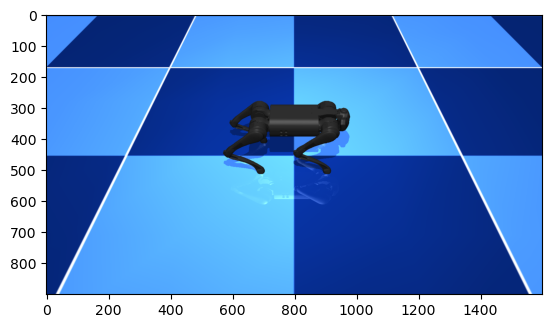

In [39]:
img = viewer.read_pixels()
plt.imshow(img)

In [40]:
data_sim.xpos

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.26      ],
       [ 0.1881    , -0.04675   ,  0.26      ],
       [ 0.1881    , -0.12675   ,  0.26      ],
       [ 0.02125137, -0.12675   ,  0.12759708],
       [ 0.1881    ,  0.04675   ,  0.26      ],
       [ 0.1881    ,  0.12675   ,  0.26      ],
       [ 0.02125137,  0.12675   ,  0.12759708],
       [-0.1881    , -0.04675   ,  0.26      ],
       [-0.1881    , -0.12675   ,  0.26      ],
       [-0.35494863, -0.12675   ,  0.12759708],
       [-0.1881    ,  0.04675   ,  0.26      ],
       [-0.1881    ,  0.12675   ,  0.26      ],
       [-0.35494863,  0.12675   ,  0.12759708]])

In [41]:
data_sim.qpos[7:]

array([ 0. ,  0.9, -1.8,  0. ,  0.9, -1.8,  0. ,  0.9, -1.8,  0. ,  0.9,
       -1.8])

In [42]:
data_sim.qpos[7:]

array([ 0. ,  0.9, -1.8,  0. ,  0.9, -1.8,  0. ,  0.9, -1.8,  0. ,  0.9,
       -1.8])

In [43]:
gait_joints_sequence[0]

array([ 0.        ,  0.88433655, -1.7686731 ,  0.        ,  0.88433655,
       -1.7686731 ,  0.        ,  0.88433655, -1.7686731 ,  0.        ,
        0.88433655, -1.7686731 ])

In [44]:
data_sim.qpos[3:7]

array([1., 0., 0., 0.])

In [45]:
data_sim.qpos[3:7] = state.quat_orientation
data_sim.qpos[7:] =  gait_joints_sequence[0]

In [46]:
mujoco.mj_forward(model_sim, data_sim)

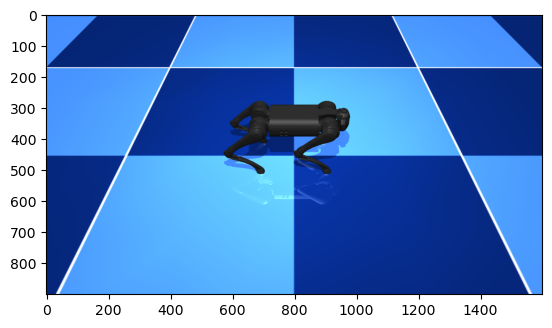

In [47]:
img = viewer.read_pixels()
plt.imshow(img)

In [48]:
%%time
anim_imgs = []
sim_inputs = []
for ticks in range(config.phase_length):
    #print(ticks)
    q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
    v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
    u_joints = gait_joints_sequence[ticks]
    data_sim.qpos[7:] = u_joints
    mujoco.mj_forward(model_sim, data_sim)
    img = viewer.read_pixels()
    anim_imgs.append(1*img)

CPU times: user 50.8 ms, sys: 90.7 ms, total: 142 ms
Wall time: 119 ms


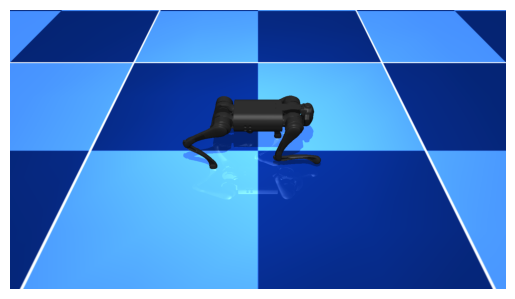

In [49]:
fig, ax = plt.subplots()
skip_frames = 1
interval = dt_sim*1000*skip_frames

def animate(i):
    ax.clear()
    ax.imshow(anim_imgs[i * skip_frames])  # Display the image, skipping frames
    ax.axis('off')

# Create animation, considering the reduced frame rate due to skipped frames
ani = FuncAnimation(fig, animate, frames=len(anim_imgs) // skip_frames, interval=interval)  # 50 ms for 20 Hz

# Display the animation
HTML(ani.to_jshtml())